In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-storm-5-0/train_kaggle.csv
/kaggle/input/data-storm-5-0/test_kaggle.csv


In [2]:
# pip install tabulate

In [3]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import optuna
from optuna.samplers import TPESampler
import re

In [4]:
train_df = pd.read_csv("/kaggle/input/data-storm-5-0/train_kaggle.csv")
test_df = pd.read_csv("/kaggle/input/data-storm-5-0/test_kaggle.csv")

/tmp/ipykernel_33/2696719607.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("/kaggle/input/data-storm-5-0/train_kaggle.csv")


In [5]:
train_df.columns

Index(['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales',
       'dry_sales', 'cluster_catgeory'],
      dtype='object')

In [6]:
train_df.dtypes

Customer_ID         float64
outlet_city          object
luxury_sales         object
fresh_sales          object
dry_sales            object
cluster_catgeory     object
dtype: object

In [7]:
test_df.dtypes

Customer_ID      int64
outlet_city     object
luxury_sales    object
fresh_sales     object
dry_sales       object
dtype: object

In [8]:
test_df.columns

Index(['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales',
       'dry_sales'],
      dtype='object')

In [9]:
train_df.head()

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
0,10493832.0,Kelaniya,1209.6,756.0,5292.0,4
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4


# **Data Cleaning**

In [10]:
train_df.isnull().sum()

Customer_ID          2
outlet_city          2
luxury_sales        35
fresh_sales         41
dry_sales           30
cluster_catgeory     1
dtype: int64

In [11]:
duplicate_rows = test_df[test_df.duplicated()]

print(duplicate_rows)

Empty DataFrame
Columns: [Customer_ID, outlet_city, luxury_sales, fresh_sales, dry_sales]
Index: []


In [12]:
test_df.isnull().sum()

Customer_ID     0
outlet_city     0
luxury_sales    0
fresh_sales     0
dry_sales       0
dtype: int64

In [13]:
len(train_df)

774155

In [14]:
train_df['cluster_catgeory'].value_counts()

cluster_catgeory
1        188975
6        169206
2        155060
4        131039
3         48906
4         41400
5         39531
5             9
1             9
6             8
2             4
3             1
6\            1
95            1
98            1
99            1
100.0         1
89.0          1
Name: count, dtype: int64

In [15]:
unique_values = train_df['cluster_catgeory'].unique()

# Get data types of the unique values
unique_value_types = {value: type(value) for value in unique_values}

# Print the unique values and their data types
for value, dtype in unique_value_types.items():
    print(f"Value: {value}, Type: {dtype}")

Value: 4, Type: <class 'str'>
Value: 1, Type: <class 'str'>
Value: 99, Type: <class 'str'>
Value: 2, Type: <class 'str'>
Value: 5, Type: <class 'str'>
Value: 3, Type: <class 'str'>
Value: 6, Type: <class 'str'>
Value: 6\, Type: <class 'str'>
Value: 4, Type: <class 'int'>
Value: 2, Type: <class 'int'>
Value: 1, Type: <class 'int'>
Value: 95, Type: <class 'int'>
Value: 3, Type: <class 'int'>
Value: 98, Type: <class 'int'>
Value: 5, Type: <class 'int'>
Value: 6, Type: <class 'int'>
Value: nan, Type: <class 'float'>
Value: 100.0, Type: <class 'float'>
Value: 89.0, Type: <class 'float'>


In [16]:
# Remove rows with cluster_category values 95, 98, 99, 100, 89, and null values
train_df = train_df[~train_df['cluster_catgeory'].isin([95, 98, '99', 100.0, 89.0]) & train_df['cluster_catgeory'].notna()]

# Convert cluster_category to string to handle all mappings
train_df['cluster_catgeory'] = train_df['cluster_catgeory'].astype(str)

# Create a mapping for valid cluster categories
valid_clusters = {'1': 1, '1.0': 1, '2': 2, '2.0': 2, '3': 3, '3.0': 3, '4': 4, '4.0': 4, '5': 5, '5.0': 5, '6': 6, '6.0': 6, '6\\': 6}

# Map the values and convert back to integers
train_df['cluster_catgeory'] = train_df['cluster_catgeory'].map(valid_clusters).astype(int)

In [17]:
train_df['cluster_catgeory'].value_counts()

cluster_catgeory
1    188984
4    172439
6    169215
2    155064
3     48907
5     39540
Name: count, dtype: int64

In [18]:
rows_with_nulls = train_df[train_df.isnull().any(axis=1)]
print(tabulate(rows_with_nulls, headers='keys', tablefmt='pretty', showindex=False))

+-------------+------------------------+--------------+-------------+-----------+------------------+
| Customer_ID |      outlet_city       | luxury_sales | fresh_sales | dry_sales | cluster_catgeory |
+-------------+------------------------+--------------+-------------+-----------+------------------+
| 10101878.0  | Dehiwala-Mount Lavinia |     nan      |   1686.36   |  9556.04  |        4         |
| 10531406.0  |        Kaduwela        |    925.8     |     nan     |  4011.8   |        4         |
| 10311229.0  |        Panadura        |     2374     |     nan     |  7715.5   |        4         |
| 10361798.0  |         Kotte          |     nan      |     nan     |  6589.44  |        4         |
| 10414692.0  |        Kaduwela        |    1780.8    |     nan     |    nan    |        4         |
| 10556752.0  |        Moratuwa        |     nan      |   1328.88   |  7751.8   |        4         |
| 10600529.0  |        Wattala         |    1405.4    |     nan     |  4637.82  |        4 

In [19]:
train = train_df.copy()

In [20]:
train['luxury_sales'] = pd.to_numeric(train['luxury_sales'], errors='coerce')
train['fresh_sales'] = pd.to_numeric(train['fresh_sales'], errors='coerce')
train['dry_sales'] = pd.to_numeric(train['dry_sales'], errors='coerce')

grouped = train.groupby(['outlet_city', 'cluster_catgeory'])

train['luxury_sales'] = grouped['luxury_sales'].transform(lambda x: x.fillna(x.mean()))
train['fresh_sales'] = grouped['fresh_sales'].transform(lambda x: x.fillna(x.mean()))
train['dry_sales'] = grouped['dry_sales'].transform(lambda x: x.fillna(x.mean()))

print(train)

        Customer_ID outlet_city  luxury_sales  fresh_sales  dry_sales  \
0        10493832.0    Kelaniya       1209.60       756.00    5292.00   
1        10178643.0    Moratuwa       1590.12      1060.08    6007.12   
2        10513916.0     Wattala       2288.88      1481.04    9155.52   
3        10334589.0     Wattala       2274.94      1739.66    9099.76   
4        10458365.0    Kelaniya       2345.49      2069.55    9243.99   
...             ...         ...           ...          ...        ...   
774150   10197979.0     Gampaha       3893.40      3893.40    3448.44   
774151   10494575.0  Katunayake       6095.86      5557.99    6275.15   
774152   10565682.0     Colombo       5121.42      4820.16    4669.53   
774153   10351977.0       Kandy       6311.76      6311.76    5940.48   
774154   10637635.0     Negombo       5833.50      6027.95    6611.30   

        cluster_catgeory  
0                      4  
1                      1  
2                      4  
3              

In [21]:
train.isnull().sum()

Customer_ID         2
outlet_city         2
luxury_sales        2
fresh_sales         2
dry_sales           2
cluster_catgeory    0
dtype: int64

In [22]:
rows_with_nulls = train[train.isnull().any(axis=1)]
print(tabulate(rows_with_nulls, headers='keys', tablefmt='pretty', showindex=False))

+-------------+-------------+--------------+-------------+-----------+------------------+
| Customer_ID | outlet_city | luxury_sales | fresh_sales | dry_sales | cluster_catgeory |
+-------------+-------------+--------------+-------------+-----------+------------------+
| 10387530.0  |     nan     |     nan      |     nan     |    nan    |        1         |
|     nan     | Trincomalee |    1682.2    |   2588.0    |  8411.0   |        1         |
|     nan     |   Jaffna    |    807.82    |   1118.52   |  4039.1   |        1         |
| 10107604.0  |     nan     |     nan      |     nan     |    nan    |        1         |
+-------------+-------------+--------------+-------------+-----------+------------------+


In [23]:
null_customer_id_mask = train['Customer_ID'].isnull()
train.loc[null_customer_id_mask, 'Customer_ID'] = np.random.randint(10000, 99999, size=null_customer_id_mask.sum())

In [24]:
rows_with_nulls = train[train.isnull().any(axis=1)]
print(tabulate(rows_with_nulls, headers='keys', tablefmt='pretty', showindex=False))

+-------------+-------------+--------------+-------------+-----------+------------------+
| Customer_ID | outlet_city | luxury_sales | fresh_sales | dry_sales | cluster_catgeory |
+-------------+-------------+--------------+-------------+-----------+------------------+
| 10387530.0  |     nan     |     nan      |     nan     |    nan    |        1         |
| 10107604.0  |     nan     |     nan      |     nan     |    nan    |        1         |
+-------------+-------------+--------------+-------------+-----------+------------------+


In [60]:
train_final = train.dropna()

In [61]:
train_final.isnull().sum()

Customer_ID         0
outlet_city         0
luxury_sales        0
fresh_sales         0
dry_sales           0
cluster_catgeory    0
dtype: int64

In [62]:
len(train_final)

774147

In [63]:
train_final['cluster_catgeory'].unique()

array([4, 1, 2, 5, 3, 6])

In [65]:
# Group by customer segment and outlet city
grouped_data = train_final.groupby(['cluster_catgeory', 'outlet_city']).mean().reset_index()

grouped_data_melted = grouped_data.melt(id_vars=['cluster_catgeory', 'outlet_city'], var_name='Sales_Type', value_name='Amount')


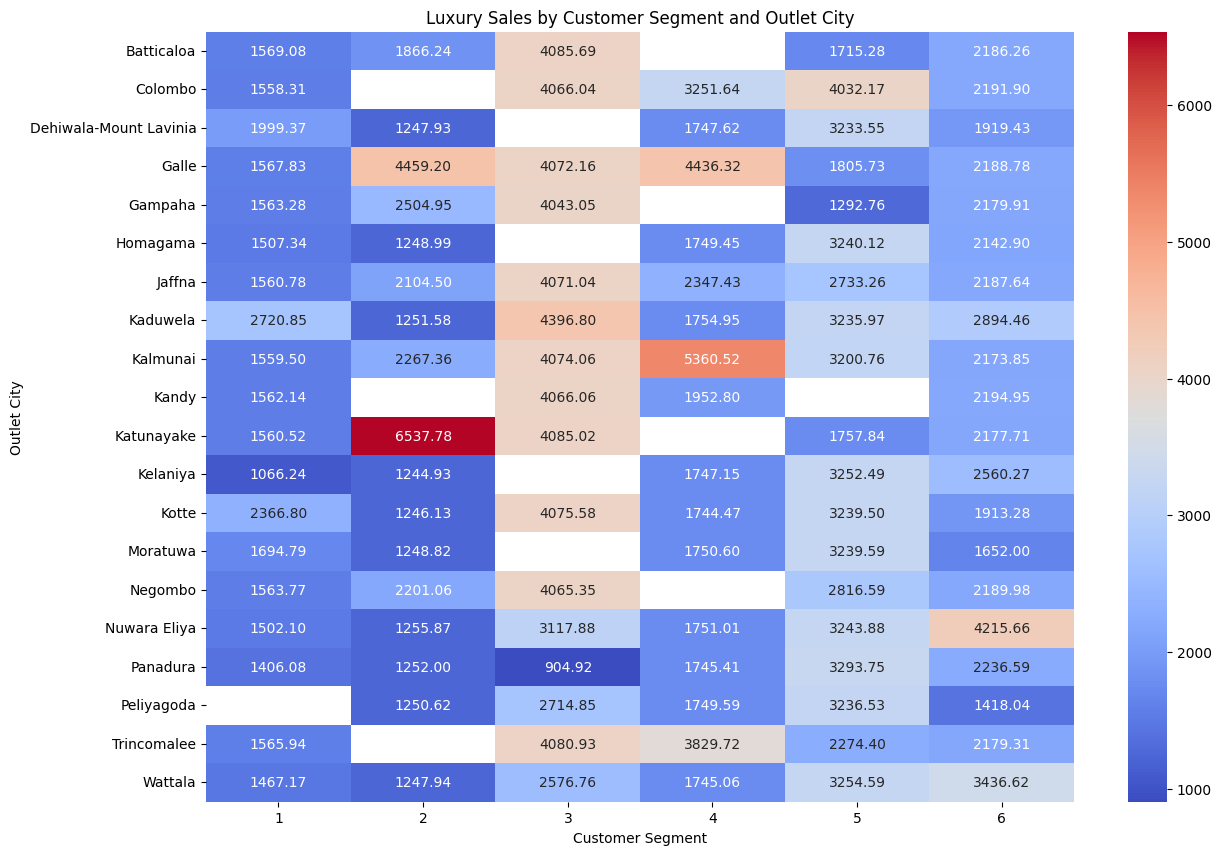

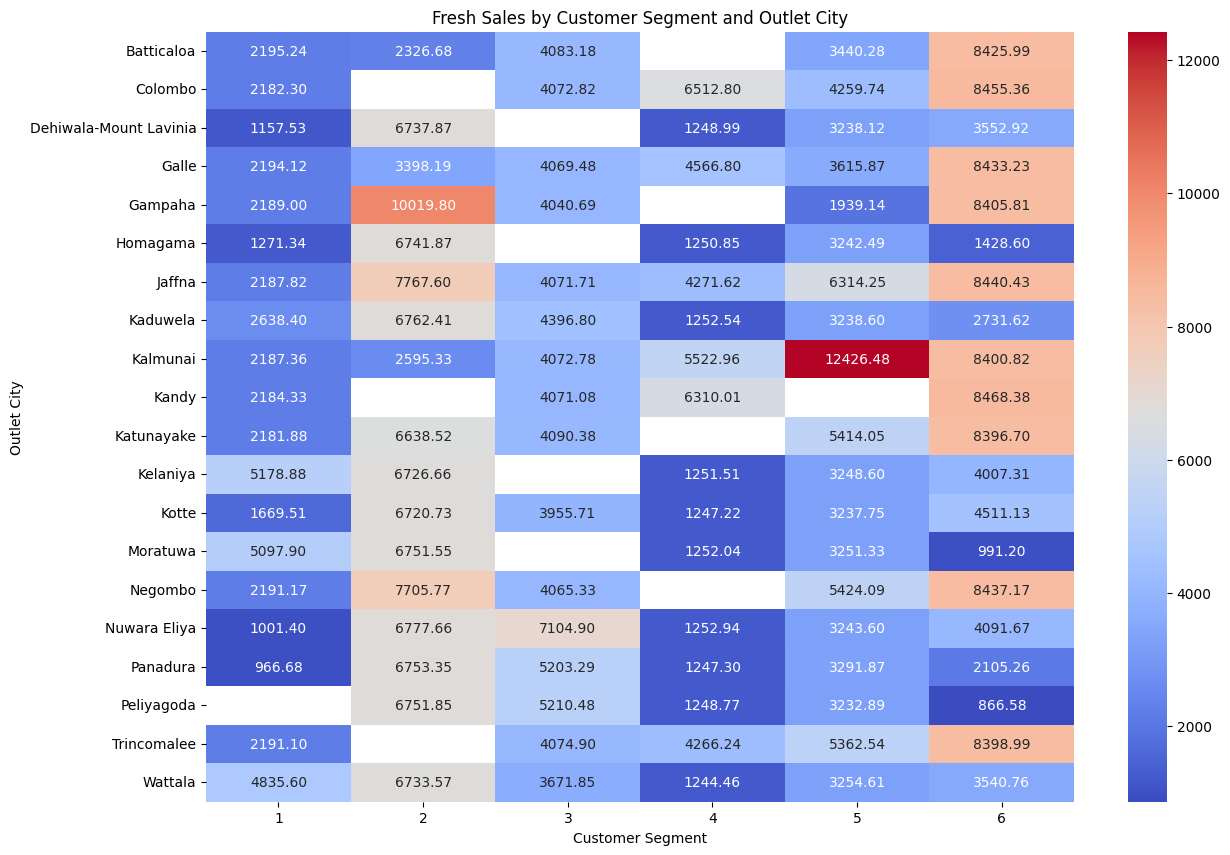

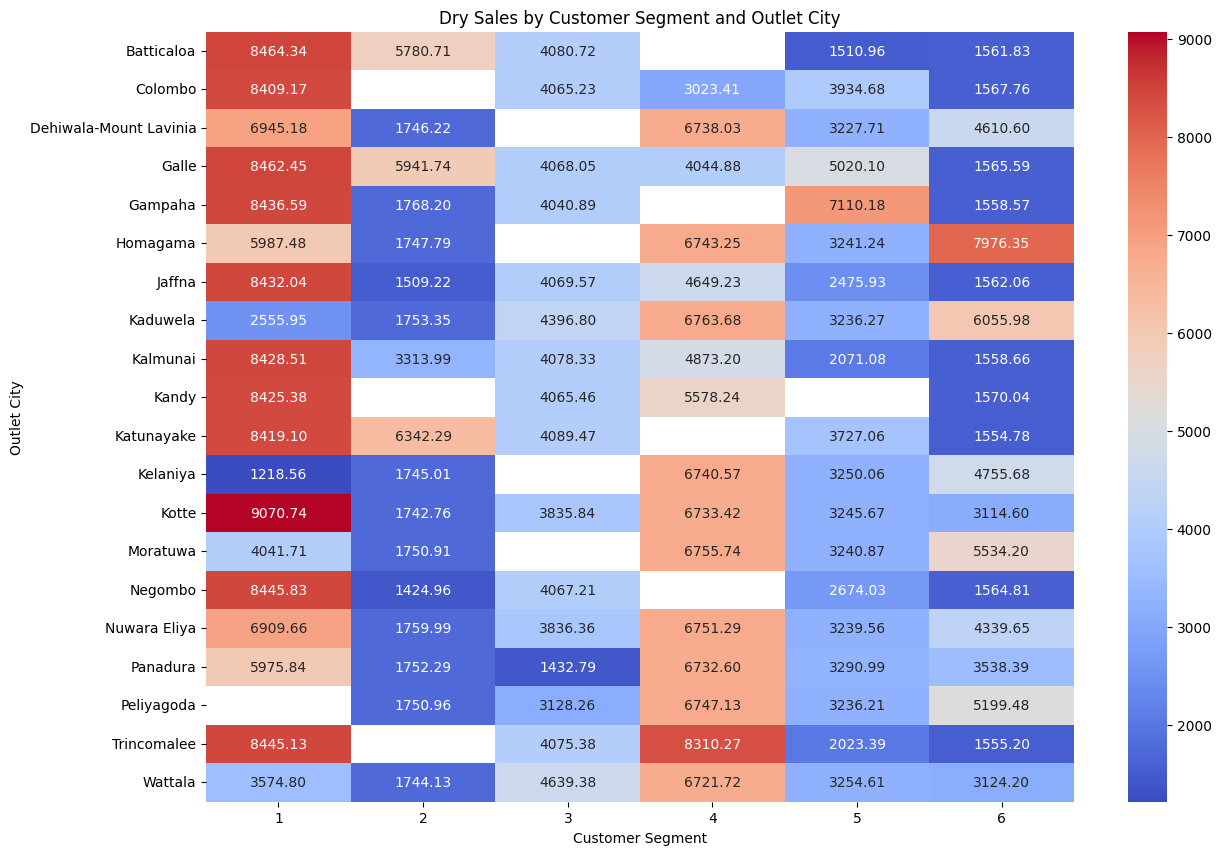

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the data for each sales type
luxury_sales_pivot = grouped_data.pivot(index='outlet_city', columns='cluster_catgeory', values='luxury_sales')
fresh_sales_pivot = grouped_data.pivot(index='outlet_city', columns='cluster_catgeory', values='fresh_sales')
dry_sales_pivot = grouped_data.pivot(index='outlet_city', columns='cluster_catgeory', values='dry_sales')

# Plot heatmap for luxury sales
plt.figure(figsize=(14, 10))
sns.heatmap(luxury_sales_pivot, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Luxury Sales by Customer Segment and Outlet City')
plt.xlabel('Customer Segment')
plt.ylabel('Outlet City')
plt.show()

# Plot heatmap for fresh sales
plt.figure(figsize=(14, 10))
sns.heatmap(fresh_sales_pivot, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Fresh Sales by Customer Segment and Outlet City')
plt.xlabel('Customer Segment')
plt.ylabel('Outlet City')
plt.show()

# Plot heatmap for dry sales
plt.figure(figsize=(14, 10))
sns.heatmap(dry_sales_pivot, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Dry Sales by Customer Segment and Outlet City')
plt.xlabel('Customer Segment')
plt.ylabel('Outlet City')
plt.show()


# **Handling outliers**

In [68]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.ensemble import IsolationForest

# Load the data
# Assuming 'train' is your DataFrame
# train = pd.read_csv('path_to_your_data.csv')

# Z-Score Method
def detect_outliers_z_score(data, threshold=3):
    outliers = []
    z_scores = np.abs(stats.zscore(data))
    outliers = np.where(z_scores > threshold)
    return outliers

# Interquartile Range (IQR) Method
def detect_outliers_iqr(data):
    outliers = []
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = np.where((data < lower_bound) | (data > upper_bound))
    return outliers


# Detecting outliers for each sales column
columns = ['luxury_sales', 'fresh_sales', 'dry_sales']
outliers_z_score = {}
outliers_iqr = {}

for column in columns:
    data = train_final[[column]].dropna()
    outliers_z_score[column] = detect_outliers_z_score(data)
    outliers_iqr[column] = detect_outliers_iqr(data)

# Print detected outliers
print("Z-Score Method Outliers:")
print(outliers_z_score)

print("\nIQR Method Outliers:")
print(outliers_iqr)



Z-Score Method Outliers:
{'luxury_sales': (array([327518, 327536, 327574, ..., 774144, 774145, 774146]), array([0, 0, 0, ..., 0, 0, 0])), 'fresh_sales': (array([], dtype=int64), array([], dtype=int64)), 'dry_sales': (array([], dtype=int64), array([], dtype=int64))}

IQR Method Outliers:
{'luxury_sales': (array([327508, 327512, 327518, ..., 774144, 774145, 774146]), array([0, 0, 0, ..., 0, 0, 0])), 'fresh_sales': (array([], dtype=int64), array([], dtype=int64)), 'dry_sales': (array([], dtype=int64), array([], dtype=int64))}


In [69]:
luxury_sales_outliers_indices = outliers_z_score['luxury_sales'][0]

# Extracting outlier values from the DataFrame
luxury_sales_outliers_values = train_final.loc[luxury_sales_outliers_indices, 'luxury_sales']

# Print or inspect the outlier values
print("Luxury Sales Outliers Values:")
print(luxury_sales_outliers_values)

Luxury Sales Outliers Values:
327518    3370.88
327536    2781.44
327574    1770.88
327578    4139.10
327580    1869.92
           ...   
774140    5736.72
774143    2154.00
774144    2695.45
774145    1644.80
774146    3796.80
Name: luxury_sales, Length: 16496, dtype: float64


In [70]:
# Assuming `train_final` is your DataFrame containing the final data

# Extracting outlier indices for 'luxury_sales' using the previously defined method
luxury_sales_outliers_indices = outliers_z_score['luxury_sales'][0]

# Extracting full rows corresponding to these outlier indices
luxury_sales_outliers_df = train_final.loc[luxury_sales_outliers_indices]

# Display the DataFrame containing the outlier rows
print("Full rows of luxury sales outliers:")
print(luxury_sales_outliers_df)


Full rows of luxury sales outliers:
        Customer_ID   outlet_city  luxury_sales  fresh_sales  dry_sales  \
327518   10376767.0      Homagama       3370.88      3476.22    3265.54   
327536   10375240.0  Nuwara Eliya       2781.44      2868.36    2868.36   
327574   10547325.0      Homagama       1770.88      1770.88    1936.90   
327578   10200110.0      Panadura       4139.10      4139.10    4139.10   
327580   10358518.0      Kaduwela       1869.92      2111.20    1930.24   
...             ...           ...           ...          ...        ...   
774140   10546925.0       Negombo       5736.72      5562.88    5910.56   
774143   10759545.0   Trincomalee       2154.00      2297.60    2225.80   
774144   10672018.0         Galle       2695.45      2782.40    2608.50   
774145   10764536.0       Colombo       1644.80      1593.40    1747.60   
774146   10134170.0       Colombo       3796.80      3678.15    3915.45   

        cluster_catgeory  
327518                 5  
327536   

In [71]:
luxury_sales_outliers_df.to_csv("sample.csv",index = False)

In [72]:
len(luxury_sales_outliers_values)

16496

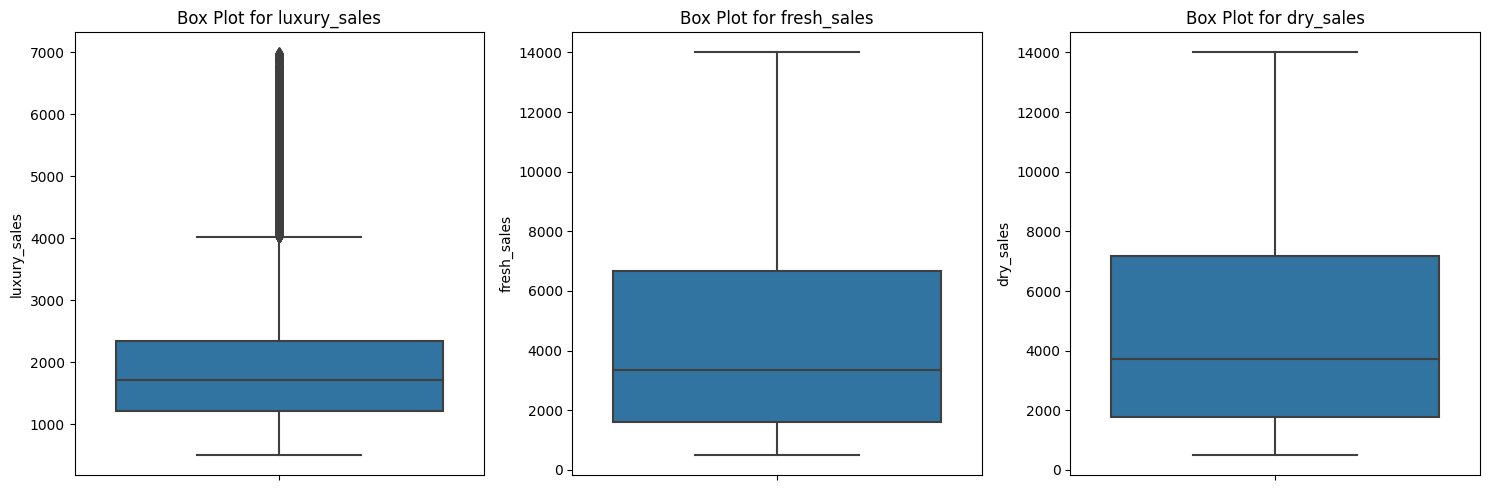

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
# Assuming 'train' is your DataFrame
# train = pd.read_csv('path_to_your_data.csv')

# Columns to check for outliers
columns = ['luxury_sales', 'fresh_sales', 'dry_sales']

# Create box plots for each column
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=train_final[column])
    plt.title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()


# **EDA**

In [74]:
print(train_final.describe())

        Customer_ID   luxury_sales    fresh_sales      dry_sales  \
count  7.741470e+05  774147.000000  774147.000000  774147.000000   
mean   1.038705e+07    1921.993558    4428.679047    4676.267755   
std    2.240978e+05    1004.088212    3334.623069    3409.359469   
min    2.455700e+04     500.000000     500.000000     500.000000   
25%    1.019354e+07    1213.560000    1620.190000    1787.940000   
50%    1.038708e+07    1715.300000    3356.540000    3727.760000   
75%    1.058062e+07    2338.700000    6671.700000    7162.200000   
max    1.077415e+07    6999.650000   13997.900000   13999.300000   

       cluster_catgeory  
count     774147.000000  
mean           3.292110  
std            1.867013  
min            1.000000  
25%            2.000000  
50%            3.000000  
75%            5.000000  
max            6.000000  


In [75]:
print(train_final['cluster_catgeory'].value_counts())

cluster_catgeory
1    188982
4    172439
6    169215
2    155064
3     48907
5     39540
Name: count, dtype: int64


In [76]:
city_mapping = {
    'MoraTuwa': 'Moratuwa',
    'Trincomale': 'Trincomalee',
    'batticaloa': 'Batticaloa',
    'kalmunai': 'Kalmunai',
    'PeliyagodA': 'Peliyagoda'
}

# Replace the values in the 'outlet_city' column
test_df['outlet_city'] = test_df['outlet_city'].replace(city_mapping)

In [77]:
test_df['outlet_city'].nunique()

22

In [78]:
train_final['outlet_city'].nunique()

20

In [79]:
print(train_final['outlet_city'].value_counts())

outlet_city
Colombo                   41031
Batticaloa                41012
Galle                     41009
Kalmunai                  40710
Negombo                   40703
Jaffna                    40675
Katunayake                40648
Kandy                     40534
Trincomalee               40528
Gampaha                   40252
Peliyagoda                37151
Nuwara Eliya              37102
Dehiwala-Mount Lavinia    36838
Kotte                     36788
Panadura                  36726
Wattala                   36721
Kaduwela                  36695
Homagama                  36638
Moratuwa                  36416
Kelaniya                  35970
Name: count, dtype: int64


In [80]:
print(test_df['outlet_city'].value_counts())

outlet_city
Kalmunai                  2233
Jaffna                    2226
Gampaha                   2198
Katunayake                2157
Negombo                   2129
Batticaloa                2119
Kandy                     2101
Colombo                   2092
Trincomalee               2072
Peliyagoda                2041
Dehiwala-Mount Lavinia    1981
Nuwara Eliya              1963
Kaduwela                  1943
Wattala                   1938
Kelaniya                  1934
Homagama                  1930
Moratuwa                  1903
Panadura                  1810
Anuradhapura              1645
Madawachiya               1499
Galle                      456
Kotte                      379
Name: count, dtype: int64


# **Data Visualization**

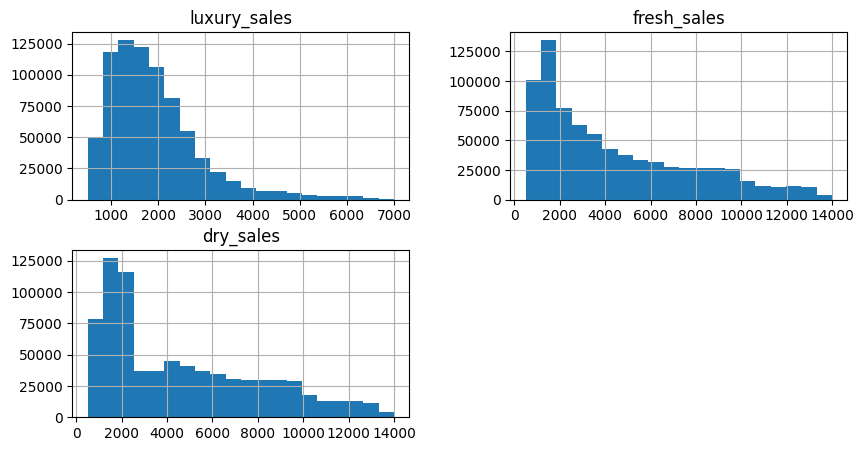

In [81]:
train_final[['luxury_sales', 'fresh_sales', 'dry_sales']].hist(bins=20, figsize=(10, 5))
plt.show()

In [82]:
train_final.columns

Index(['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales',
       'dry_sales', 'cluster_catgeory'],
      dtype='object')

In [83]:
train_final

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
0,10493832.0,Kelaniya,1209.60,756.00,5292.00,4
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4
...,...,...,...,...,...,...
774150,10197979.0,Gampaha,3893.40,3893.40,3448.44,3
774151,10494575.0,Katunayake,6095.86,5557.99,6275.15,3
774152,10565682.0,Colombo,5121.42,4820.16,4669.53,3
774153,10351977.0,Kandy,6311.76,6311.76,5940.48,3


In [84]:
# corr = train_final[['cluster_catgeory','luxury_sales', 'fresh_sales', 'dry_sales', 'total_sales', 'luxury_sales_ratio', 'fresh_sales_ratio', 'dry_sales_ratio']].corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.show()

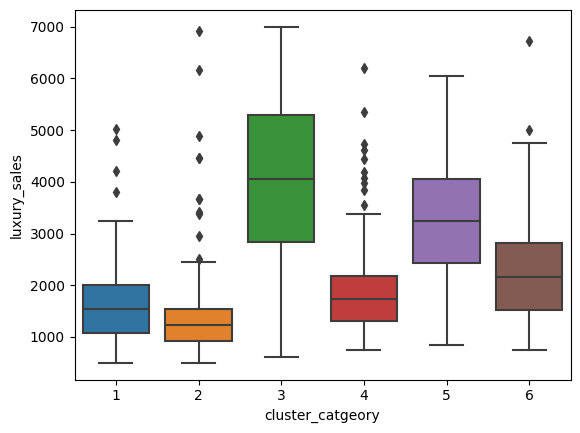

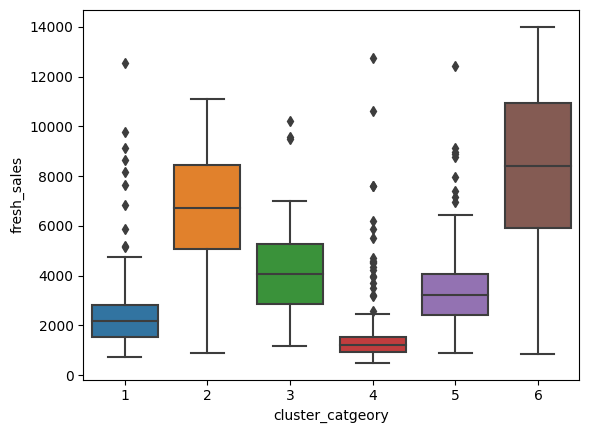

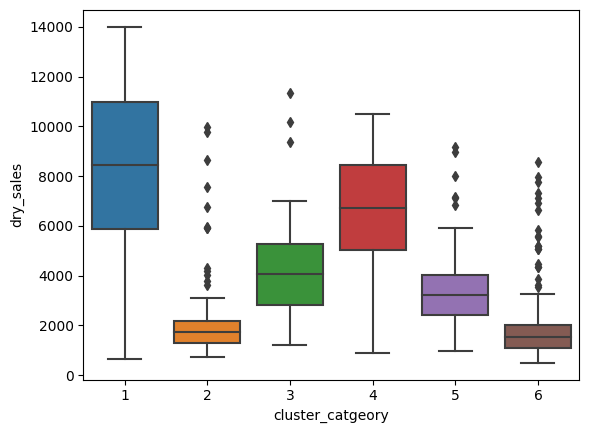

In [85]:
sns.boxplot(x='cluster_catgeory', y='luxury_sales', data=train_final)
plt.show()
sns.boxplot(x='cluster_catgeory', y='fresh_sales', data=train_final)
plt.show()
sns.boxplot(x='cluster_catgeory', y='dry_sales', data=train_final)
plt.show()

/tmp/ipykernel_33/2766063160.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[0], x='cluster_catgeory', y='luxury_sales', data=train_final, ci=None)
/tmp/ipykernel_33/2766063160.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[1], x='cluster_catgeory', y='fresh_sales', data=train_final, ci=None)
/tmp/ipykernel_33/2766063160.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(ax=axes[2], x='cluster_catgeory', y='dry_sales', data=train_final, ci=None)


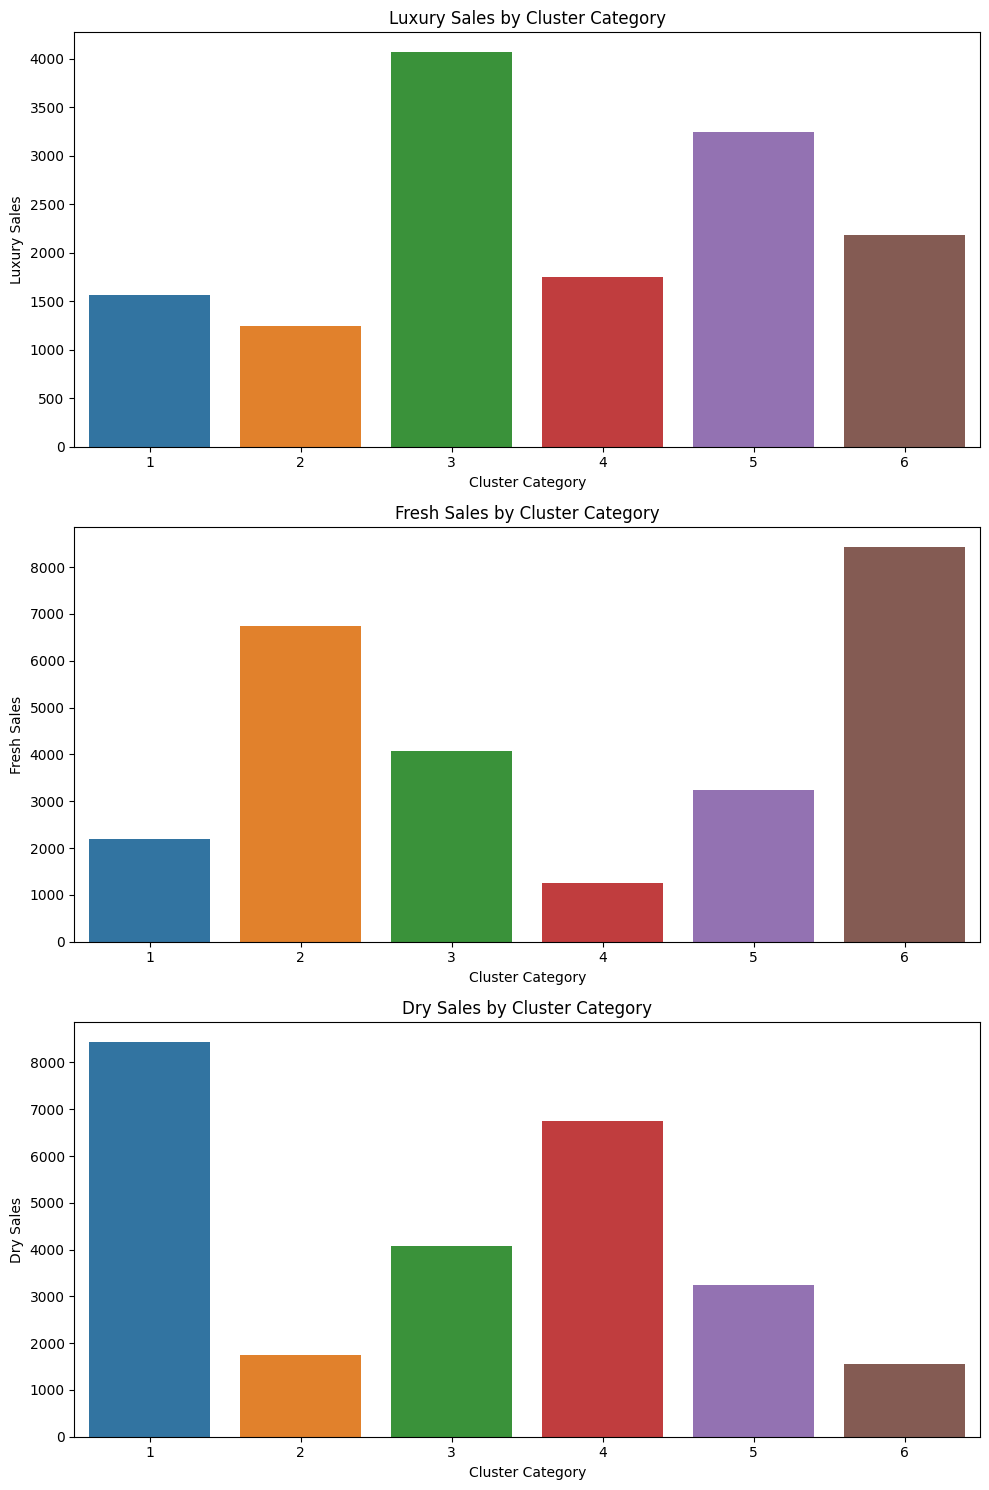

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sns.barplot(ax=axes[0], x='cluster_catgeory', y='luxury_sales', data=train_final, ci=None)
axes[0].set_title('Luxury Sales by Cluster Category')
axes[0].set_xlabel('Cluster Category')
axes[0].set_ylabel('Luxury Sales')

sns.barplot(ax=axes[1], x='cluster_catgeory', y='fresh_sales', data=train_final, ci=None)
axes[1].set_title('Fresh Sales by Cluster Category')
axes[1].set_xlabel('Cluster Category')
axes[1].set_ylabel('Fresh Sales')

sns.barplot(ax=axes[2], x='cluster_catgeory', y='dry_sales', data=train_final, ci=None)
axes[2].set_title('Dry Sales by Cluster Category')
axes[2].set_xlabel('Cluster Category')
axes[2].set_ylabel('Dry Sales')

plt.tight_layout()

plt.show()

# **Feature Engineering**

In [87]:
train_final['total_sales'] = train_final['luxury_sales'] + train_final['fresh_sales'] + train_final['dry_sales']
train_final['luxury_sales_ratio'] = train_final['luxury_sales'] / train_final['total_sales']
train_final['fresh_sales_ratio'] = train_final['fresh_sales'] / train_final['total_sales']
train_final['dry_sales_ratio'] = train_final['dry_sales'] / train_final['total_sales']

train_final = pd.get_dummies(train_final, columns=['outlet_city'], drop_first=True)

one_hot_encoded_columns = [col for col in train_final.columns if col.startswith('outlet_city_')]

train_final[one_hot_encoded_columns] = train_final[one_hot_encoded_columns].astype(int)


/tmp/ipykernel_33/1887580065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final['total_sales'] = train_final['luxury_sales'] + train_final['fresh_sales'] + train_final['dry_sales']
/tmp/ipykernel_33/1887580065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_final['luxury_sales_ratio'] = train_final['luxury_sales'] / train_final['total_sales']
/tmp/ipykernel_33/1887580065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [88]:
# Assuming 'customer_segment' is the target variable
segments = train_final['cluster_catgeory'].unique()

# Summary statistics for each segment
summary_stats = train_final.groupby('cluster_catgeory').describe()
print(summary_stats)


                 Customer_ID                                           \
                       count          mean            std         min   
cluster_catgeory                                                        
1                   188982.0  1.038659e+07  226004.029542     24557.0   
2                   155064.0  1.038681e+07  223731.267292  10000001.0   
3                    48907.0  1.038724e+07  223298.364600  10000003.0   
4                   172439.0  1.038740e+07  223574.150297  10000002.0   
5                    39540.0  1.038818e+07  222962.285944  10000024.0   
6                   169215.0  1.038711e+07  223323.932636  10000000.0   

                                                                    \
                          25%         50%          75%         max   
cluster_catgeory                                                     
1                 10193159.50  10386975.5  10580256.75  10774149.0   
2                 10191989.75  10386960.5  10580852.00  107741

In [92]:
behavior_features = ['luxury_sales', 'fresh_sales', 'dry_sales']


# Analyze purchasing behavior
behavior_analysis = train_final.groupby('cluster_catgeory')[behavior_features].mean()
print(behavior_analysis)


                  luxury_sales  fresh_sales    dry_sales
cluster_catgeory                                        
1                  1563.125291  2188.481625  8436.597892
2                  1249.653814  6745.625668  1749.531157
3                  4070.672126  4071.401729  4069.969310
4                  1748.639902  1249.942482  6742.640648
5                  3246.459361  3248.645300  3246.208800
6                  2185.052173  8425.677120  1562.301899


In [93]:
behavior_analysis = behavior_analysis.reset_index()

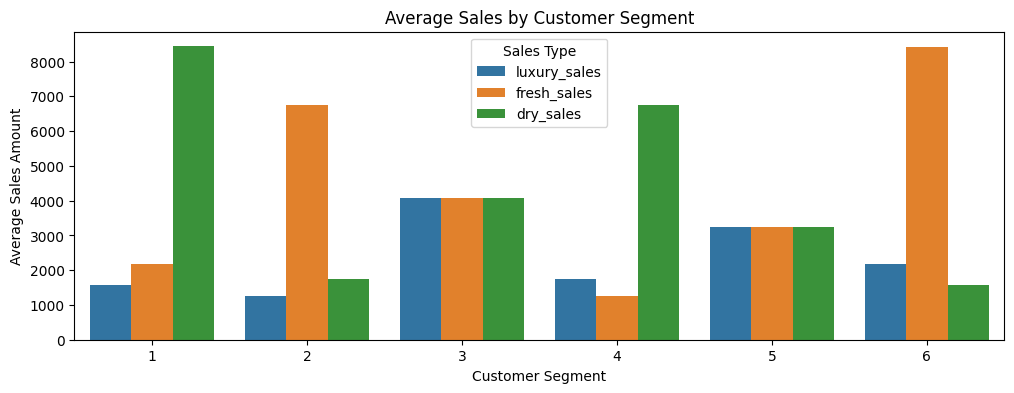

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(behavior_analysis)

# Melt the DataFrame for easier plotting
df_melted = df.melt(id_vars='cluster_catgeory', var_name='Sales_Type', value_name='Amount')

# Plot the data
plt.figure(figsize=(12, 4))
sns.barplot(x='cluster_catgeory', y='Amount', hue='Sales_Type', data=df_melted)
plt.title('Average Sales by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Sales Amount')
plt.legend(title='Sales Type')
plt.show()


In [95]:
customer_ids = [10364, 4059,28662,28664]

# Filter rows based on Customer_ID
filtered_df = test_df[test_df['Customer_ID'].isin(customer_ids)]

print(filtered_df.head())

       Customer_ID   outlet_city                       luxury_sales  \
6            10364    Batticaloa   Seven Hundread and sixty Ruppees   
6299          4059  Anuradhapura  Eight Hundread and fifteen ruppes   
13949        28662        Jaffna                            2195.84   
40746        28664       Wattala                             3838.6   

                 fresh_sales                              dry_sales  
6                      914.4                                 3352.8  
6299                 1548.69                                 5705.7  
13949  Nine thousand ruppess                                1509.64  
40746                 3951.5  Three Thousand seven hundread ruppees  


In [96]:
test_df.loc[test_df['Customer_ID'] == 10364, 'luxury_sales'] = 760
test_df.loc[test_df['Customer_ID'] == 4059, 'luxury_sales'] = 815
test_df.loc[test_df['Customer_ID'] == 28662, 'fresh_sales'] = 9000
test_df.loc[test_df['Customer_ID'] == 28664, 'dry_sales'] = 3700

In [97]:
customer_ids = [10364, 4059,28662,28664]

# Filter rows based on Customer_ID
filtered_df = test_df[test_df['Customer_ID'].isin(customer_ids)]

print(filtered_df.head())

       Customer_ID   outlet_city luxury_sales fresh_sales dry_sales
6            10364    Batticaloa          760       914.4    3352.8
6299          4059  Anuradhapura          815     1548.69    5705.7
13949        28662        Jaffna      2195.84        9000   1509.64
40746        28664       Wattala       3838.6      3951.5      3700


In [98]:
test_df.isnull().sum()

Customer_ID     0
outlet_city     0
luxury_sales    0
fresh_sales     0
dry_sales       0
dtype: int64

In [99]:
test_df['luxury_sales'] = pd.to_numeric(test_df['luxury_sales'], errors='coerce')
test_df['fresh_sales'] = pd.to_numeric(test_df['fresh_sales'], errors='coerce')
test_df['dry_sales'] = pd.to_numeric(test_df['dry_sales'], errors='coerce')

In [100]:
test_df['total_sales'] = test_df['luxury_sales'] + test_df['fresh_sales'] + test_df['dry_sales']
test_df['luxury_sales_ratio'] = test_df['luxury_sales'] / test_df['total_sales']
test_df['fresh_sales_ratio'] = test_df['fresh_sales'] / test_df['total_sales']
test_df['dry_sales_ratio'] = test_df['dry_sales'] / test_df['total_sales']

test_df = pd.get_dummies(test_df, columns=['outlet_city'], drop_first=True)
test_df = test_df.astype(int)

In [101]:
num_columns = len(test_df.columns)
print("Number of columns:", num_columns)

Number of columns: 29


In [102]:
num_columns = len(train_final.columns)
print("Number of columns:", num_columns)

Number of columns: 28


In [103]:
train_final.columns

Index(['Customer_ID', 'luxury_sales', 'fresh_sales', 'dry_sales',
       'cluster_catgeory', 'total_sales', 'luxury_sales_ratio',
       'fresh_sales_ratio', 'dry_sales_ratio', 'outlet_city_Colombo',
       'outlet_city_Dehiwala-Mount Lavinia', 'outlet_city_Galle',
       'outlet_city_Gampaha', 'outlet_city_Homagama', 'outlet_city_Jaffna',
       'outlet_city_Kaduwela', 'outlet_city_Kalmunai', 'outlet_city_Kandy',
       'outlet_city_Katunayake', 'outlet_city_Kelaniya', 'outlet_city_Kotte',
       'outlet_city_Moratuwa', 'outlet_city_Negombo',
       'outlet_city_Nuwara Eliya', 'outlet_city_Panadura',
       'outlet_city_Peliyagoda', 'outlet_city_Trincomalee',
       'outlet_city_Wattala'],
      dtype='object')

In [104]:
test_df.columns

Index(['Customer_ID', 'luxury_sales', 'fresh_sales', 'dry_sales',
       'total_sales', 'luxury_sales_ratio', 'fresh_sales_ratio',
       'dry_sales_ratio', 'outlet_city_Batticaloa', 'outlet_city_Colombo',
       'outlet_city_Dehiwala-Mount Lavinia', 'outlet_city_Galle',
       'outlet_city_Gampaha', 'outlet_city_Homagama', 'outlet_city_Jaffna',
       'outlet_city_Kaduwela', 'outlet_city_Kalmunai', 'outlet_city_Kandy',
       'outlet_city_Katunayake', 'outlet_city_Kelaniya', 'outlet_city_Kotte',
       'outlet_city_Madawachiya', 'outlet_city_Moratuwa',
       'outlet_city_Negombo', 'outlet_city_Nuwara Eliya',
       'outlet_city_Panadura', 'outlet_city_Peliyagoda',
       'outlet_city_Trincomalee', 'outlet_city_Wattala'],
      dtype='object')

In [105]:
train_final

,Customer_ID,luxury_sales,fresh_sales,dry_sales,cluster_catgeory,total_sales,luxury_sales_ratio,fresh_sales_ratio,dry_sales_ratio,outlet_city_Colombo,...,outlet_city_Katunayake,outlet_city_Kelaniya,outlet_city_Kotte,outlet_city_Moratuwa,outlet_city_Negombo,outlet_city_Nuwara Eliya,outlet_city_Panadura,outlet_city_Peliyagoda,outlet_city_Trincomalee,outlet_city_Wattala
0,10493832.0,1209.60,756.00,5292.00,4,7257.60,0.166667,0.104167,0.729167,0,...,0,1,0,0,0,0,0,0,0,0
1,10178643.0,1590.12,1060.08,6007.12,1,8657.32,0.183673,0.122449,0.693878,0,...,0,0,0,1,0,0,0,0,0,0
2,10513916.0,2288.88,1481.04,9155.52,4,12925.44,0.177083,0.114583,0.708333,0,...,0,0,0,0,0,0,0,0,0,1
3,10334589.0,2274.94,1739.66,9099.76,4,13114.36,0.173469,0.132653,0.693878,0,...,0,0,0,0,0,0,0,0,0,1
4,10458365.0,2345.49,2069.55,9243.99,4,13659.03,0.171717,0.151515,0.676768,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774150,10197979.0,3893.40,3893.40,3448.44,3,11235.24,0.346535,0.346535,0.306931,0,...,0,0,0,0,0,0,0,0,0,0
774151,10494575.0,6095.86,5557.99,6275.15,3,17929.00,0.340000,0.310000,0.350000,0,...,1,0,0,0,0,0,0,0,0,0
774152,10565682.0,5121.42,4820.16,4669.53,3,14611.11,0.350515,0.329897,0.319588,1,...,0,0,0,0,0,0,0,0,0,0
774153,10351977.0,6311.76,6311.76,5940.48,3,18564.00,0.340000,0.340000,0.320000,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
features = train_final.columns.difference(['cluster_catgeory'])
target = 'cluster_catgeory'

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_final[features], train_final[target], test_size=0.2, random_state=42)



In [107]:
# def objective(trial):
#     # Define parameters to optimize
#     params = {
#         'objective': 'multiclass',
#         'num_class': len(set(y_train)),
#         'metric': 'multi_logloss',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'max_depth': trial.suggest_int('max_depth', 2, 32),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
#     }

#     # Train LightGBM model with early stopping
#     model = lgb.LGBMClassifier(**params)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_test, y_test)],
#         eval_metric='multi_logloss'
#     )
    
#     # Predictions
#     y_pred = model.predict(X_test)
    
#     # Calculate accuracy
#     accuracy = accuracy_score(y_test, y_pred)
    
#     return 1 - accuracy

# # Create Optuna study
# study = optuna.create_study(direction='minimize', sampler=TPESampler())
# study.optimize(objective, n_trials=20)

# # Get best parameters
# best_params = study.best_params
# print("Best parameters found: ", best_params)

# **LGBM**

In [108]:
lgbm_params = {'learning_rate': 0.07906917295854136,
 'num_leaves': 150,
 'max_depth': 5,
 'min_child_samples': 11,
 'subsample': 0.510509952546856,
 'colsample_bytree': 0.8996539123767988,
 'reg_alpha': 9.986760761800257,
 'reg_lambda': 6.410878926609608,
 'n_estimators': 848,}

In [109]:
from lightgbm import LGBMRegressor

In [110]:
lgbm_model = LGBMRegressor(**lgbm_params)

In [111]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1914
[LightGBM] [Info] Number of data points in the train set: 619317, number of used features: 27
[LightGBM] [Info] Start training from score 3.293489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ed7b0ca1bd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 224, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ed7b0ca1bd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 224, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ed7b0ca1bd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 224, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ed7b0ca1bd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 224, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Exception ignored on calling ctypes callback function: <function _log_callback at 0x7ed7b0ca1bd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 224, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMRegressor(colsample_bytree=0.8996539123767988,
              learning_rate=0.07906917295854136, max_depth=5,
              min_child_samples=11, n_estimators=848, num_leaves=150,
              reg_alpha=9.986760761800257, reg_lambda=6.410878926609608,
              subsample=0.510509952546856)

In [ ]:
y_pred = lgbm_model.predict(X_test)

In [ ]:
y_pred

In [ ]:
y_pred_rounded = np.round(y_pred).astype(int)

print(y_pred_rounded)

In [ ]:
len(y_pred_rounded)

In [ ]:
len(y_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_rounded)

print("Accuracy Score:", accuracy)

# **Voting regressor**

In [ ]:
lgbm_params = {'learning_rate': 0.07906917295854136,
 'num_leaves': 150,
 'max_depth': 5,
 'min_child_samples': 11,
 'subsample': 0.510509952546856,
 'colsample_bytree': 0.8996539123767988,
 'reg_alpha': 9.986760761800257,
 'reg_lambda': 6.410878926609608,
 'n_estimators': 848,}

xgb_params = {
    'learning_rate': 0.03707790908518306,
    'max_depth': 10,
    'min_child_weight': 9,
    'subsample': 0.8967647035944689,
    'colsample_bytree': 0.9090722551215268,
    'reg_alpha': 0.35516821239781227,
    'reg_lambda': 5.333613737874481,
    'gamma': 0.02779543179803734,
    'n_estimators': 643,
    'colsample_bylevel': 0.7781667558241238,
    'colsample_bynode': 0.6629827491722804,
    'max_delta_step': 7,
    'scale_pos_weight': 6.243083080071807,
    'max_leaves': 210,
}

cat_params = {
    'iterations': 711,
    'learning_rate': 0.03829257605331949,
    'depth': 10,
    'l2_leaf_reg': 0.24655372809493836,
    'border_count': 247,
    'bagging_temperature': 0.836026146474483,
    'random_strength': 0.38876695375300657,
    'grow_policy': 'Lossguide',
    'min_data_in_leaf': 50,
    'leaf_estimation_method': 'Gradient',
    'feature_border_type': 'MinEntropy',
    'boosting_type': 'Plain',
}

In [ ]:
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [ ]:
lgbm_model = LGBMRegressor(**lgbm_params)
xgb_model = XGBRegressor(**xgb_params)
catboost_model = CatBoostRegressor(**cat_params)

In [ ]:
voting_regressor = VotingRegressor(estimators=[
    ('lgbm', lgbm_model),
    ('xgb', xgb_model),
    ('catboost', catboost_model)
])

In [ ]:
voting_regressor.fit(X_train, y_train)

In [ ]:
y_pred = voting_regressor.predict(X_test)

In [ ]:
y_pred_rounded = np.round(y_pred).astype(int)

print(y_pred_rounded)

In [ ]:
len(y_pred_rounded)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_rounded)

print("Accuracy Score:", accuracy)

# **Prediction**

In [ ]:
y_pred_test = voting_regressor.predict(test_df)

In [ ]:
y_pred_rounded_test = np.round(y_pred_test).astype(int)

print(y_pred_rounded_test)

In [ ]:
customer_id_column = test_df['Customer_ID']

submission_df = pd.DataFrame(customer_id_column)
print(submission_df)